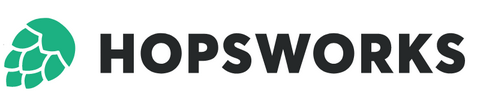

# Data Validation using Hopsworks integration with Great Expectations 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/logicalclocks/hopsworks-tutorials/blob/master/fraud_batch/1_feature_groups.ipynb)

**Note**: you may get an error when installing hopsworks on Colab, and it is safe to ignore it.

The purpose of this notebook is to extend on part 1 of the fraud_batch tutorial to showcase how **Hopsworks Feature Store** integrates seamlessly with **Great Expectations (GE) library** to perform data validation. Simply define an expectation suite in GE and attach it to a Feature Group. Hopsworks will automatically run validation on insert and centralize your expectation suite as well as validation reports. In addition, you can check the validation history directly in the Feature Group UI page.


## 🗒️ This notebook is divided in 6 sections:
1. Loading the data and feature engineering,
2. Connect to the Hopsworks feature store,
3. Define Data Validation Pipeline using Great Expectation,
4. Setup Validation on Insert and upload data,
5. Explore Validation Report in Hopsworks UI.

![tutorial-flow](https://github.com/logicalclocks/hopsworks-tutorials/blob/master/images/01_featuregroups.png?raw=1)

First of all we will load the data and do some feature engineering on it.

In [1]:
!pip install -U hopsworks --quiet

     |████████████████████████████████| 119 kB 48.6 MB/s 
     |████████████████████████████████| 51 kB 8.2 MB/s 
     |████████████████████████████████| 132 kB 60.4 MB/s 
     |████████████████████████████████| 45 kB 3.7 MB/s 
     |████████████████████████████████| 68 kB 7.7 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 4.9 MB 47.4 MB/s 
     |████████████████████████████████| 42 kB 1.9 MB/s 
     |████████████████████████████████| 2.8 MB 15.6 MB/s 
     |████████████████████████████████| 2.3 MB 45.5 MB/s 
     |████████████████████████████████| 67 kB 6.1 MB/s 
     |████████████████████████████████| 109 kB 19.8 MB/s 
     |████████████████████████████████| 546 kB 50.3 MB/s 
     |████████████████████████████████| 79 kB 5.1 MB/s 
     |████████████████████████████████| 9.0 MB 14.1 MB/s 
     |████████████████████████████████| 127 kB 6.6 MB/s 
     |████████████████████████████████| 59 kB 3.2 MB/s 
     |█████████████████████████

## <span style="color:#ff5f27;"> 💽 Loading the Data </span>

The data we will use comes from three different CSV files:

- `credit_cards.csv`: credit card information such as expiration date and provider.
- `transactions.csv`: transaction information such as timestamp, location, and the amount. Importantly, the binary `fraud_label` variable tells us whether a transaction was fraudulent or not.
- `profiles.csv`: credit card user information such as birthdate and city of residence.

We can conceptualize these CSV files as originating from separate data sources.
**All three files have a credit card number column `cc_num` in common, which we can use for joins.**

Let's go ahead and load the data.

In [2]:
import pandas as pd
credit_cards_df = pd.read_csv("https://repo.hops.works/master/hopsworks-tutorials/data/card_fraud_data/credit_cards.csv")
credit_cards_df.head(3)

cc_num provider expires
0  4796807885357879     visa   05/23
1  4529266636192966     visa   03/22
2  4922690008243953     visa   02/27

In [3]:
profiles_df = pd.read_csv("https://repo.hops.works/master/hopsworks-tutorials/data/card_fraud_data/profiles.csv", parse_dates=["birthdate"])
profiles_df.head(3)

name sex                       mail  birthdate  \
0  Catherine Zimmerman   F  valenciajason@hotmail.com 1988-09-20   
1     Michael Williams   M     brettkennedy@yahoo.com 1977-03-01   
2      Jessica Krueger   F     marthacruz@hotmail.com 1947-09-10   

                City Country            cc_num  
0   Bryn Mawr-Skyway      US  4796807885357879  
1  Gates-North Gates      US  4529266636192966  
2         Greenfield      US  4922690008243953

In [4]:
trans_df = pd.read_csv("https://repo.hops.works/master/hopsworks-tutorials/data/card_fraud_data/transactions.csv", parse_dates=["datetime"])
trans_df.head(3)

tid            datetime            cc_num  \
0  11df919988c134d97bbff2678eb68e22 2022-01-01 00:00:24  4473593503484549   
1  dd0b2d6d4266ccd3bf05bc2ea91cf180 2022-01-01 00:00:56  4272465718946864   
2  e627f5d9a9739833bd52d2da51761fc3 2022-01-01 00:02:32  4104216579248948   

             category  amount  latitude  longitude            city country  \
0       Health/Beauty   62.95  42.30865  -83.48216          Canton      US   
1             Grocery   85.45  33.52253 -117.70755   Laguna Niguel      US   
2  Domestic Transport   21.63  37.60876  -77.37331  Mechanicsville      US   

   fraud_label  
0            0  
1            0  
2            0

## <span style="color:#ff5f27;"> 🛠️ Feature Engineering </span>

Fraudulent transactions can differ from regular ones in many different ways. Typical red flags would for instance be a large transaction volume/frequency in the span of a few hours. It could also be the case that elderly people in particular are targeted by fraudsters. To facilitate model learning we will create additional features based on these patterns. In particular, we will create two types of features:
1. **Features that aggregate data from different data sources**. This could for instance be the age of a customer at the time of a transaction, which combines the `birthdate` feature from `profiles.csv` with the `datetime` feature from `transactions.csv`.
2. **Features that aggregate data from multiple time steps**. An example of this could be the transaction frequency of a credit card in the span of a few hours, which is computed using a window function.

Let's start with the first category.

In [5]:
import numpy as np

# Compute age at transaction.
age_df = trans_df.merge(profiles_df, on="cc_num", how="left")
trans_df["age_at_transaction"] = (age_df["datetime"] - age_df["birthdate"]) / np.timedelta64(1, "Y")

# Compute days until card expires.
card_expiry_df = trans_df.merge(credit_cards_df, on="cc_num", how="left")
card_expiry_df["expires"] = pd.to_datetime(card_expiry_df["expires"], format="%m/%y")
trans_df["days_until_card_expires"] = (card_expiry_df["expires"] - card_expiry_df["datetime"]) / np.timedelta64(1, "D")

trans_df[["age_at_transaction", "days_until_card_expires"]].head()

age_at_transaction  days_until_card_expires
0           97.513297              1460.999722
1           33.752919              1733.999352
2           80.899681               242.998241
3           53.526088               150.997639
4           46.005059               515.997280

Next, we create features that for each credit card aggregate data from multiple time steps.

We start by computing the distance between consecutive transactions, which we will call `loc_delta`.
Here we use the [Haversine distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html?highlight=haversine#sklearn.metrics.pairwise.haversine_distances) to quantify the distance between two longitude and latitude coordinates.

In [6]:
from math import radians

# Do some simple preprocessing.
trans_df.sort_values("datetime", inplace=True)
trans_df[["longitude", "latitude"]] = trans_df[["longitude", "latitude"]].applymap(radians)

def haversine(long, lat):
    """Compute Haversine distance between each consecutive coordinate in (long, lat)."""

    long_shifted = long.shift()
    lat_shifted = lat.shift()
    long_diff = long_shifted - long
    lat_diff = lat_shifted - lat

    a = np.sin(lat_diff/2.0)**2
    b = np.cos(lat) * np.cos(lat_shifted) * np.sin(long_diff/2.0)**2
    c = 2*np.arcsin(np.sqrt(a + b))

    return c


trans_df["loc_delta"] = trans_df.groupby("cc_num")\
    .apply(lambda x : haversine(x["longitude"], x["latitude"]))\
    .reset_index(level=0, drop=True)\
    .fillna(0)

Next we compute windowed aggregates. Here we will use 4-hour windows, but feel free to experiment with different window lengths by setting `window_len` below to a value of your choice.

In [7]:
window_len = "4h"
cc_group = trans_df[["cc_num", "amount", "datetime"]].groupby("cc_num").rolling(window_len, on="datetime")

# Moving average of transaction volume.
df_4h_mavg = pd.DataFrame(cc_group.mean())
df_4h_mavg.columns = ["trans_volume_mavg", "datetime"]
df_4h_mavg = df_4h_mavg.reset_index(level=["cc_num"])
df_4h_mavg = df_4h_mavg.drop(columns=["cc_num", "datetime"])
df_4h_mavg = df_4h_mavg.sort_index()

# Moving standard deviation of transaction volume.
df_4h_std = pd.DataFrame(cc_group.mean())
df_4h_std.columns = ["trans_volume_mstd", "datetime"]
df_4h_std = df_4h_std.reset_index(level=["cc_num"])
df_4h_std = df_4h_std.drop(columns=["cc_num", "datetime"])
df_4h_std = df_4h_std.fillna(0)
df_4h_std = df_4h_std.sort_index()
window_aggs_df = df_4h_std.merge(df_4h_mavg,left_index=True, right_index=True)

# Moving average of transaction frequency.
df_4h_count = pd.DataFrame(cc_group.mean())
df_4h_count.columns = ["trans_freq", "datetime"]
df_4h_count = df_4h_count.reset_index(level=["cc_num"])
df_4h_count = df_4h_count.drop(columns=["cc_num", "datetime"])
df_4h_count = df_4h_count.sort_index()
window_aggs_df = window_aggs_df.merge(df_4h_count,left_index=True, right_index=True)

# Moving average of location difference between consecutive transactions.
cc_group = trans_df[["cc_num", "loc_delta", "datetime"]].groupby("cc_num").rolling(window_len, on="datetime").mean()
df_4h_loc_delta_mavg = pd.DataFrame(cc_group)
df_4h_loc_delta_mavg.columns = ["loc_delta_mavg", "datetime"]
df_4h_loc_delta_mavg = df_4h_loc_delta_mavg.reset_index(level=["cc_num"])
df_4h_loc_delta_mavg = df_4h_loc_delta_mavg.drop(columns=["cc_num", "datetime"])
df_4h_loc_delta_mavg = df_4h_loc_delta_mavg.sort_index()
window_aggs_df = window_aggs_df.merge(df_4h_loc_delta_mavg,left_index=True, right_index=True)

window_aggs_df = window_aggs_df.merge(trans_df[["cc_num", "datetime"]].sort_index(),left_index=True, right_index=True)
window_aggs_df.tail()

trans_volume_mstd  trans_volume_mavg  trans_freq  loc_delta_mavg  \
106015              73.08              73.08       73.08        0.045635   
106016             287.33             287.33      287.33        0.045846   
106017              53.88              53.88       53.88        0.000120   
106018             279.73             279.73      279.73        0.045928   
106019              73.66              73.66       73.66        0.045974   

                  cc_num            datetime  
106015  4032019521897961 2022-03-24 10:57:02  
106016  4032019521897961 2022-03-28 11:57:02  
106017  4032019521897961 2022-04-01 12:57:02  
106018  4032019521897961 2022-04-05 13:57:02  
106019  4032019521897961 2022-04-09 14:57:02

### Convert date time object to unix epoch in milliseconds

In [8]:
trans_df.datetime = trans_df.datetime.values.astype(np.int64) // 10 ** 6
window_aggs_df.datetime = window_aggs_df.datetime.values.astype(np.int64) // 10 ** 6

## <span style="color:#ff5f27;"> 🪄 Creating Feature Groups </span>

A [feature group](https://docs.hopsworks.ai/feature-store-api/latest/generated/feature_group/) can be seen as a collection of conceptually related features. In our case, we will create a feature group for the transaction data and a feature group for the windowed aggregations on the transaction data. Both will have `cc_num` as primary key, which will allow us to join them when creating a dataset in the next tutorial.

Feature groups can also be used to define a namespace for features. For instance, in a real-life setting we would likely want to experiment with different window lengths. In that case, we can create feature groups with identical schema for each window length. 

Before we can create a feature group we need to connect to our feature store.

In [30]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.
Connection closed.
Copy your Api Key (first register/login): https://c.app.hopsworks.ai/account/api/generated

Paste it here: I1GJfbJAfL2WQNrb.RA1oJvSmLXCLFX1G669lczYnaJ08oSotWNsi7lAgpoWYOQPgfZP6zLeutkdCQRk0
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/155
Connected. Call `.close()` to terminate connection gracefully.


To create a feature group we need to give it a name and specify a primary key. It is also good to provide a description of the contents of the feature group and a version number, if it is not defined it will automatically be incremented to `1`.

In [40]:
trans_fg = fs.get_or_create_feature_group(
    name="transactions_fraud_batch_fg",
    version=1,
    description="Transaction data",
    primary_key=['cc_num'],
    event_time=['datetime']
)

A full list of arguments can be found in the [documentation](https://docs.hopsworks.ai/feature-store-api/latest/generated/api/feature_store_api/#create_feature_group).

At this point, we have only specified some metadata for the feature group. It does not store any data or even have a schema defined for the data. To make the feature group persistent we populate it with its associated data using the `insert` function. We are inserting a single row here.

In [41]:
trans_fg.insert(trans_df.head(1))

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/155/fs/97/fg/555


Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/155/jobs/named/transactions_fraud_batch_fg_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x7fd06acf8b90>, None)

In [42]:
feature_descriptions = [
    {"name": "tid", "description": "Transaction id"},
    {"name": "datetime", "description": "Transaction time"},
    {"name": "cc_num", "description": "Number of the credit card performing the transaction"},
    {"name": "category", "description": "Expense category"},
    {"name": "amount", "description": "Dollar amount of the transaction"},
    {"name": "latitude", "description": "Transaction location latitude"},
    {"name": "longitude", "description": "Transaction location longitude"},
    {"name": "city", "description": "City in which the transaction was made"},
    {"name": "country", "description": "Country in which the transaction was made"},
    {"name": "fraud_label", "description": "Whether the transaction was fraudulent or not"},
    {"name": "age_at_transaction", "description": "Age of the card holder when the transaction was made"},
    {"name": "days_until_card_expires", "description": "Card validity days left when the transaction was made"},
    {"name": "loc_delta", "description": "Haversine distance between this transaction location and the previous transaction location from the same card"},
]

for desc in feature_descriptions: 
    trans_fg.update_feature_description(desc["name"], desc["description"])

At the creation of the feature group, you will prompted with an URL that will directly link to it; there you will be able to explore some of the aspects of your newly created feature group.

[//]: <> (insert GIF here)

We can move on and do the same thing for the feature group with our windows aggregation.

In [43]:
window_aggs_fg = fs.get_or_create_feature_group(
    name=f"transactions_{window_len}_aggs_fraud_batch_fg",
    version=1,
    description=f"Aggregate transaction data over {window_len} windows.",
    primary_key=['cc_num'],
    event_time=['datetime']
)

In [44]:
window_aggs_fg.insert(window_aggs_df.head(1))

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/155/fs/97/fg/556


Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/155/jobs/named/transactions_4h_aggs_fraud_batch_fg_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x7fd06acbeed0>, None)

In [45]:
feature_descriptions = [
    {"name": "datetime", "description": "Transaction time"},
    {"name": "cc_num", "description": "Number of the credit card performing the transaction"},
    {"name": "loc_delta_mavg", "description": "Moving average of location difference between consecutive transactions from the same card"},
    {"name": "trans_freq", "description": "Moving average of transaction frequency from the same card"},
    {"name": "trans_volume_mavg", "description": "Moving average of transaction volume from the same card"},
    {"name": "trans_volume_mstd", "description": "Moving standard deviation of transaction volume from the same card"},
]

for desc in feature_descriptions: 
    window_aggs_fg.update_feature_description(desc["name"], desc["description"])

Both feature groups are now accessible and searchable in the UI

![fg-overview](https://github.com/logicalclocks/hopsworks-tutorials/blob/master/images/fg_overview.gif?raw=1)

### Define Data Validation Pipeline using Great Expectations

An Expectation Suite in Great Expectations contains multiple expectations which will be evaluated against a DataFrame on validation. This step will generate a report gathering information on whether the DataFrame fullfill those expectations. Setup the validation pipeline using the usual GE object and syntax, once your expectation suite is ready register it with the Hopsworks backend.

In [46]:
import great_expectations as ge
from great_expectations.core import ExpectationSuite, ExpectationConfiguration

expectation_suite_trans = ExpectationSuite(expectation_suite_name="trans_df")

You can now generate an expectation suite and populate it with various expectation configuration. Many standard expectations are implemented in Great Expectations from computing the mean of a column to counting the number of null values for example.

In [47]:
# Check for errors which could lead to technical issues

expectation_suite_trans.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_unique",
        kwargs={"column":"tid", "result_format":"COMPLETE"}
    )
)

expectation_suite_trans.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_in_set",
        kwargs={
            "column":"fraud_label",
            "value_set": [0,1]
        }
    )
)

# Assess data correctness

expectation_suite_trans.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_min_to_be_between",
        kwargs={
            "column":"amount",
            "min_value":0
        }
    )
)

expectation_suite_trans.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_min_to_be_between",
        kwargs={
            "column":"age_at_transaction",
            "min_value": 18,
            "max_value": 130
        }
    )
)

# Or simply to monitor data statistics and quality, e.g number of null values

expectation_suite_trans.add_expectation(
    ExpectationConfiguration(
      expectation_type="expect_column_mean_to_be_between",
      kwargs={"column":"age_at_transaction", "min_value": 0, "max_value": 100}
    )
)

expectation_suite_trans.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_value_to_be_null",
        kwargs={"column":"category"}
    )
)


{"expectation_type": "expect_column_value_to_be_null", "kwargs": {"column": "category"}, "meta": {}}

In [48]:
ge_trans_df = ge.from_pandas(trans_df, expectation_suite=expectation_suite_trans)

validation_report_trans = ge_trans_df.validate()

When prototyping an expectation suite you can use Great Expectations DataFrame wrapper to evaluate expectation directly and enable auto-complete.

In [49]:
ge_window_aggs_df = ge.from_pandas(window_aggs_df)

# Check if window_aggs_df is sorted according to datetime
validation_result = ge_window_aggs_df.expect_column_values_to_be_increasing(
    column="datetime",
    strictly=True
)

print(validation_result)

{
  "result": {
    "element_count": 106020,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 6325,
    "unexpected_percent": 5.96585549896246,
    "unexpected_percent_total": 5.96585549896246,
    "unexpected_percent_nonmissing": 5.96585549896246,
    "partial_unexpected_list": [
      1641014149000,
      1641022955000,
      1641031742000,
      1641049228000,
      1641076464000,
      1641093569000,
      1641105971000,
      1641118522000,
      1641165387000,
      1641174584000,
      1641205656000,
      1641219627000,
      1641232522000,
      1641253431000,
      1641262683000,
      1641268045000,
      1641286728000,
      1641294096000,
      1641315090000,
      1641340229000
    ]
  },
  "expectation_config": {
    "expectation_type": "expect_column_values_to_be_increasing",
    "kwargs": {
      "column": "datetime",
      "strictly": true,
      "result_format": "BASIC"
    },
    "meta": {}
  },
  "exception_info": {
    "raised_exception"

Niote that this does not append the expectation to the suite, however the result contains all the necessary information to recreate the expectation. 

In [22]:
expectation_suite_window = ge_window_aggs_df.get_expectation_suite()
expectation_suite_window.expectation_suite_name = "window_aggs_suite"
print(expectation_suite_window)

{
  "expectations": [],
  "expectation_suite_name": "window_aggs_suite",
  "ge_cloud_id": null,
  "data_asset_type": "Dataset",
  "meta": {
    "great_expectations_version": "0.14.3"
  }
}


In [28]:
expectation_suite_window.add_expectation(validation_result["expectation_config"])
print(expectation_suite_window)

{
  "expectations": [
    {
      "expectation_type": "expect_column_values_to_be_increasing",
      "kwargs": {
        "column": "datetime",
        "strictly": true,
        "result_format": "BASIC"
      },
      "meta": {}
    }
  ],
  "expectation_suite_name": "window_aggs_suite",
  "ge_cloud_id": null,
  "data_asset_type": "Dataset",
  "meta": {
    "great_expectations_version": "0.14.3"
  }
}


### Setup Validation On Insert and Upload Data

Register the expectation suite corresponding to a Feature Group with the backend

In [50]:
# The "ALWAYS" ingestion policy inserts data even when validation fails, 
# ideal to avoid data loss and rapid prototyping
trans_fg.save_expectation_suite(expectation_suite_trans, validation_ingestion_policy="ALWAYS")

# The "STRICT" ingestion policy only inserts data when data validation succeeds,
# perfect for production environment 
window_aggs_fg.save_expectation_suite(expectation_suite_window, validation_ingestion_policy="STRICT")

Attached expectation suite to featuregroup, edit it at https://c.app.hopsworks.ai:443/p/155/fs/97/fg/555
Attached expectation suite to featuregroup, edit it at https://c.app.hopsworks.ai:443/p/155/fs/97/fg/556


Once the suite is registered in the backend, data validation will run on every insert without additional boilerplate. The suite is retrieved from the backend, used to validate the DataFrame and the resulting validation report uploaded. Depending on the ingestion policy and validation success, data are subsequently inserted in the Feature Group.

In [52]:
trans_job, trans_report = trans_fg.insert(trans_df)

Validation Report saved successfully, explore a summary at https://c.app.hopsworks.ai:443/p/155/fs/97/fg/555


Uploading Dataframe: 0.00% |          | Rows 0/106020 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/155/jobs/named/transactions_fraud_batch_fg_1_offline_fg_backfill/executions


The "STRICTLY" ingestion policy aborts insertion job if the validation fails.

In [55]:
window_aggs_job, window_aggs_report = window_aggs_fg.insert(window_aggs_df)

Validation Report saved successfully, explore a summary at https://c.app.hopsworks.ai:443/p/155/fs/97/fg/556


### Explore the Validation Reports in Hopsworks UI

Follow the links to explore a summary of the validation reports generated by Great Expectations directly in the Feature Group page!

Despite some expectations in the validation step raising exception or failing, you can see that the trans DataFrame has been inserted in the Feature Group. In the validation results tab, you can see one expectation fail was caused by an unexpected young customer making a transaction. You can download the full report to investigate errors like exception or more complex results.


On the other hand, setting the ingestion policy to "STRICT" for the window_agg_fg lead to the abortion of the insertion job. You can however bypass the validation if needed (e.g. time critical backfilling)

In [56]:
window_aggs_fg.insert(window_aggs_df, validation_options={"run_validation": False})

Uploading Dataframe: 0.00% |          | Rows 0/106020 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/155/jobs/named/transactions_4h_aggs_fraud_batch_fg_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x7fd06f37aa50>, None)